In [498]:
import pandas as pd
import os
import csv
from pathlib import Path
import hvplot.pandas
import requests
import numpy
from scipy.stats import linregress 
import matplotlib.pyplot as plt
import seaborn as sns


# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [418]:
# Input cvs raw data to data frames
delays_df = pd.read_csv("Airline_Delay_Cause.csv")
delays_df.head()


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,5,G7,GoJet Airlines LLC d/b/a United Express,ORD,"Chicago, IL: Chicago O'Hare International",621.0,128.0,24.75,12.43,...,0.00,36.72,7.0,10.0,15126.0,1707.0,3005.0,4454.0,0.0,5960.0
1,2024,5,HA,Hawaiian Airlines Network,AUS,"Austin, TX: Austin - Bergstrom International",15.0,3.0,3.00,0.00,...,0.00,0.00,0.0,0.0,135.0,135.0,0.0,0.0,0.0,0.0
2,2024,5,HA,Hawaiian Airlines Network,BOS,"Boston, MA: Logan International",20.0,8.0,6.19,0.07,...,0.90,0.85,0.0,0.0,609.0,313.0,17.0,0.0,233.0,46.0
3,2024,5,HA,Hawaiian Airlines Network,JFK,"New York, NY: John F. Kennedy International",31.0,8.0,7.57,0.00,...,0.43,0.00,0.0,0.0,274.0,262.0,0.0,0.0,12.0,0.0
4,2024,5,HA,Hawaiian Airlines Network,LAS,"Las Vegas, NV: Harry Reid International",124.0,14.0,11.00,1.00,...,0.00,2.00,1.0,0.0,543.0,420.0,27.0,0.0,0.0,96.0


In [570]:
# Display data columns
print(delays_df.columns)

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')



Number of entries per carrier in the filtered DataFrame:
carrier_name
Delta Air Lines Network      1822
American Airlines Network    1768
United Air Lines Network     1716
Southwest Airlines           1592
Name: count, dtype: int64

Average Arrival Delays for Selected Carriers:
carrier_name
American Airlines Network    28813.447964
Southwest Airlines           20759.460427
Delta Air Lines Network      17977.544457
United Air Lines Network     17266.699125
Name: arr_delay, dtype: float64


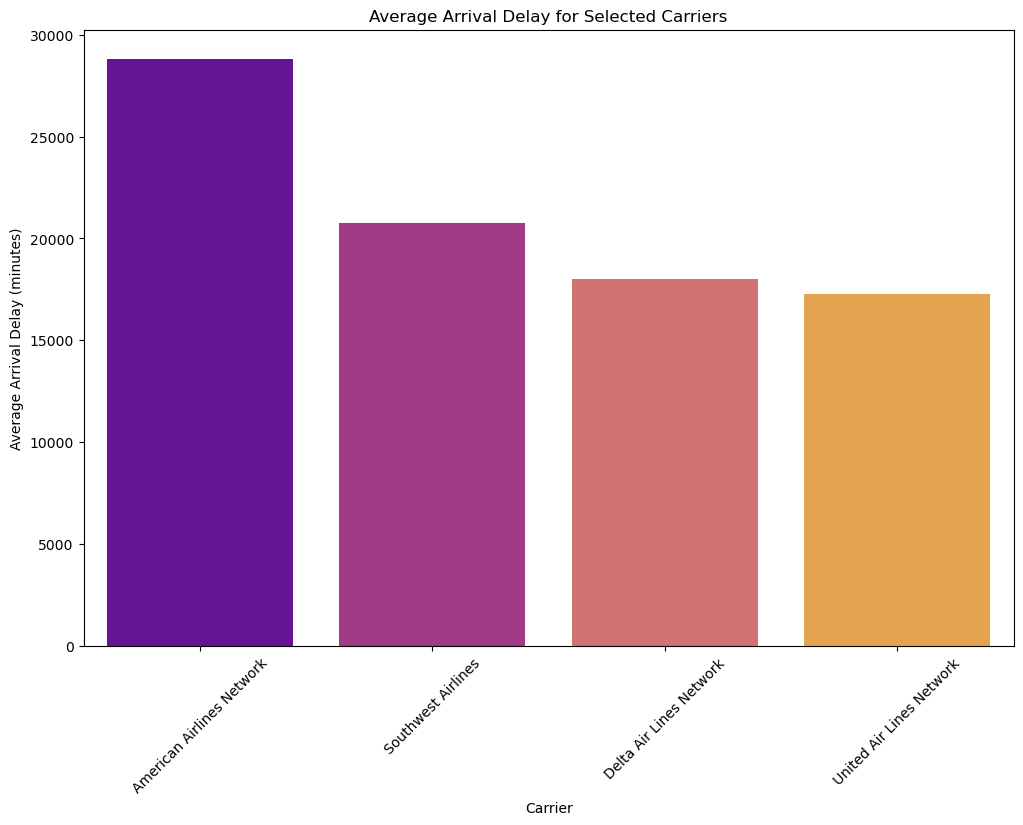

In [518]:
# List of carriers to filter
target_carriers = ['Southwest Airlines','Delta Air Lines Network', 'United Air Lines Network','American Airlines Network']

# Filter the DataFrame for the specified carriers
filtered_df = delays_df[delays_df['carrier_name'].isin(target_carriers)]

# Check the number of entries for each carrier after filtering
print("\nNumber of entries per carrier in the filtered DataFrame:")
print(filtered_df['carrier_name'].value_counts())

# Calculate average arrival delay by carrier for the filtered data
carrier_delay = filtered_df.groupby('carrier_name')['arr_delay'].mean().sort_values(ascending=False)

# Display average delays for the specified carriers
print("\nAverage Arrival Delays for Selected Carriers:")
print(carrier_delay)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=carrier_delay.index, y=carrier_delay.values, palette='plasma')
plt.xticks(rotation=45)
plt.xlabel('Carrier')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay for Selected Carriers')
plt.show()

In [562]:
# Summarize the data by airport
airport_delay_summary = delays_df.groupby(['airport', 'airport_name']).agg({
  'arr_flights': 'sum',
   'arr_del15': 'sum'
     }).reset_index()

# Calculate the delay rate (percentage of delayed flights)
airport_delay_summary['delay_rate'] = (airport_delay_summary['arr_del15'] / airport_delay_summary['arr_flights']) * 100

# Sort airports by delay rate in descending order to find those with the highest rates
top_airports_by_delay_rate = airport_delay_summary.sort_values(by='delay_rate', ascending=False).head(10)

# Print the top 10 airports by delay rate
print("Top 10 US Airports by Delay Rate:")
print(top_airports_by_delay_rate[['airport', 'airport_name', 'arr_flights', 'arr_del15', 'delay_rate']])


Top 10 US Airports by Delay Rate:
   airport                                       airport_name  arr_flights  \
15     LAS            Las Vegas, NV: Harry Reid International     344036.0   
19     MCO                 Orlando, FL: Orlando International     705925.0   
10     EWR           Newark, NJ: Newark Liberty International     645994.0   
11     FLL  Fort Lauderdale, FL: Fort Lauderdale-Hollywood...     431563.0   
14     JFK        New York, NY: John F. Kennedy International     544103.0   
30     TPA                     Tampa, FL: Tampa International     357771.0   
3      BOS                    Boston, MA: Logan International     606482.0   
1      AUS       Austin, TX: Austin - Bergstrom International     365609.0   
21     MIA                     Miami, FL: Miami International     466432.0   
28     SFO     San Francisco, CA: San Francisco International     632514.0   

    arr_del15  delay_rate  
15    85663.0   24.899429  
19   158311.0   22.426037  
10   144516.0   22.3711

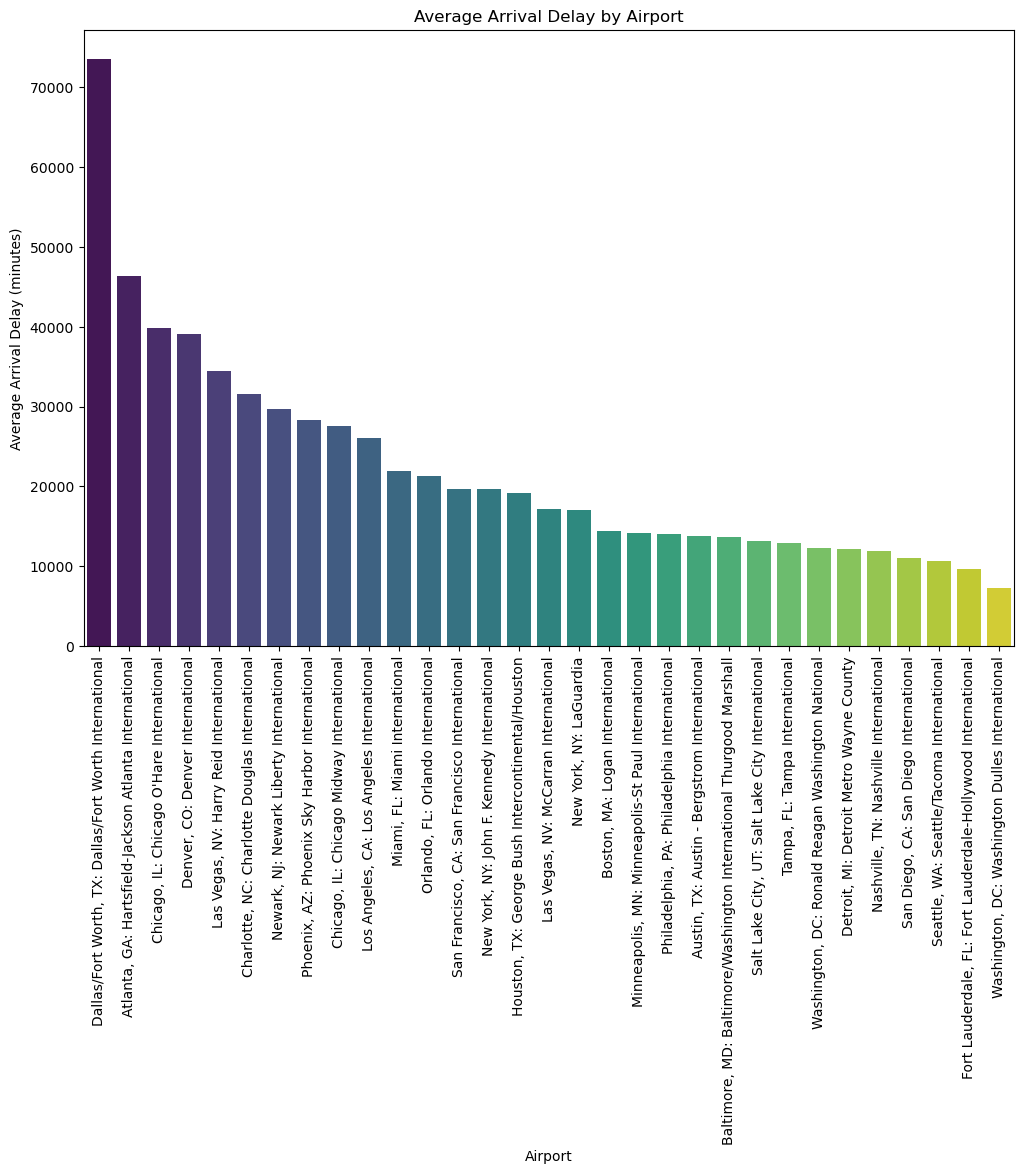

In [572]:
airport_delay = filtered_df.groupby('airport_name')['arr_delay'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=airport_delay.index, y=airport_delay.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Airport')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Airport')
plt.show()

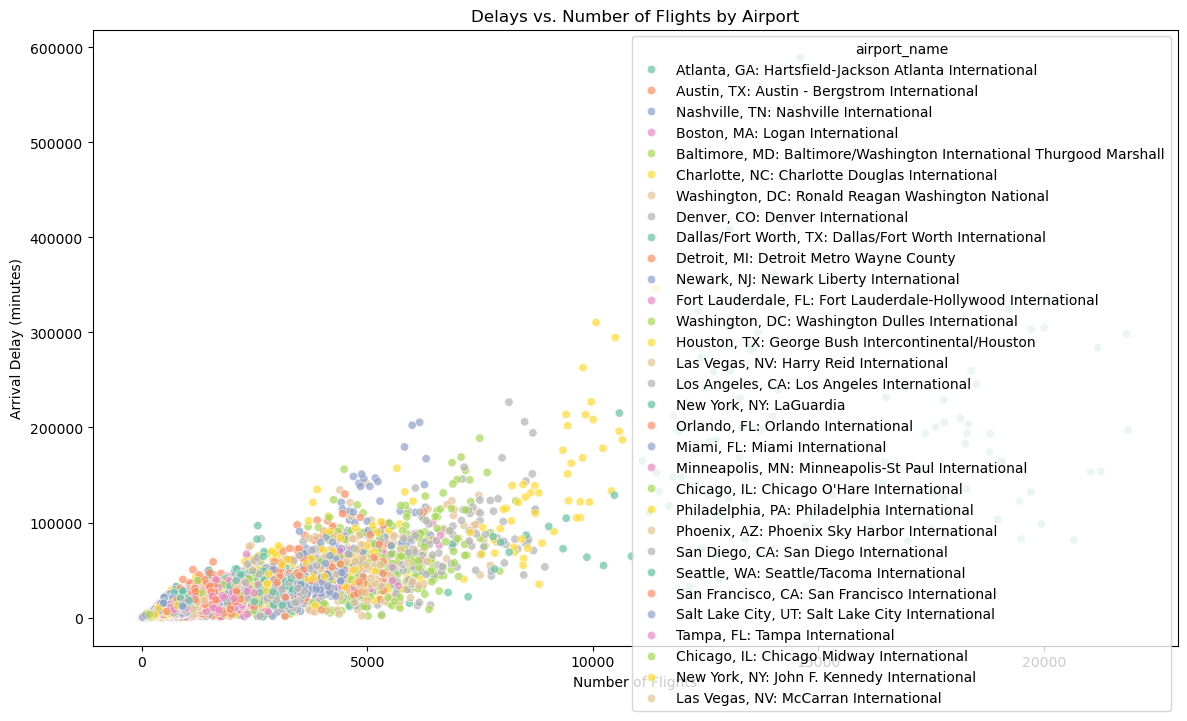

In [530]:
# Plot delays vs. number of flights
plt.figure(figsize=(14, 8))
sns.scatterplot(x='arr_flights', y='arr_delay', data=filtered_df, hue='airport_name', palette='Set2', alpha=0.7)
plt.xlabel('Number of Flights')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Delays vs. Number of Flights by Airport')
plt.show()

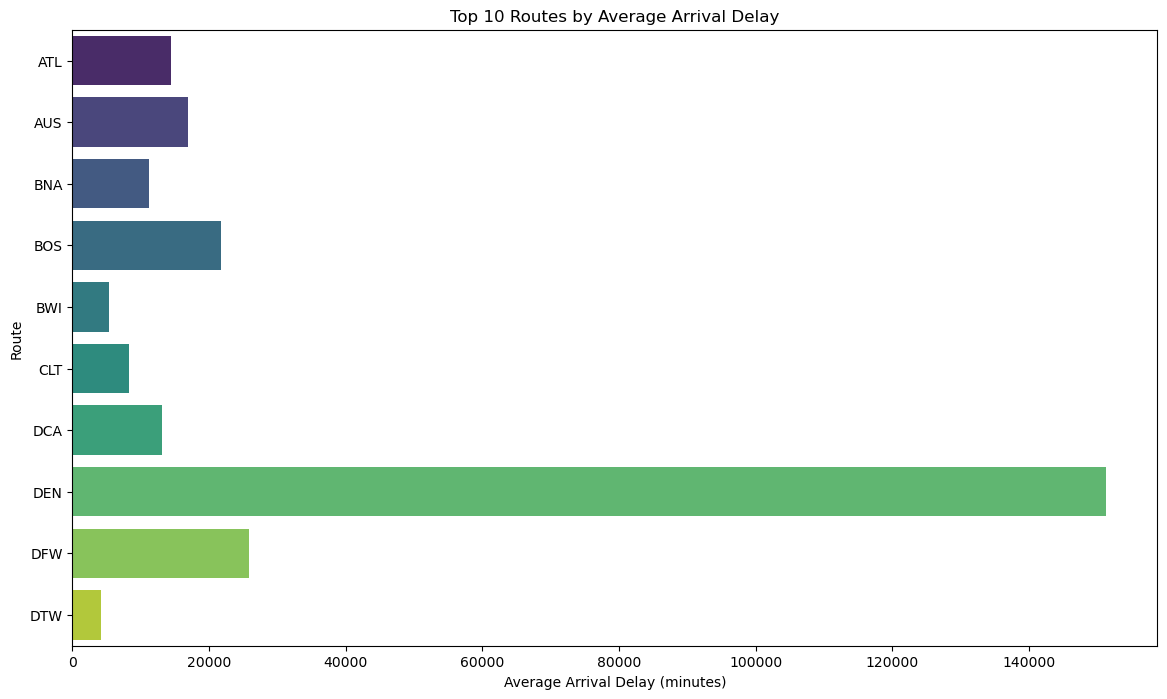

In [536]:
# Plot average arrival delays by route
plt.figure(figsize=(14, 8))
sns.barplot(x='arr_delay', y='airport', data=filtered_df.head(10), palette='viridis')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Route')
plt.title('Top 10 Routes by Average Arrival Delay')
plt.show()

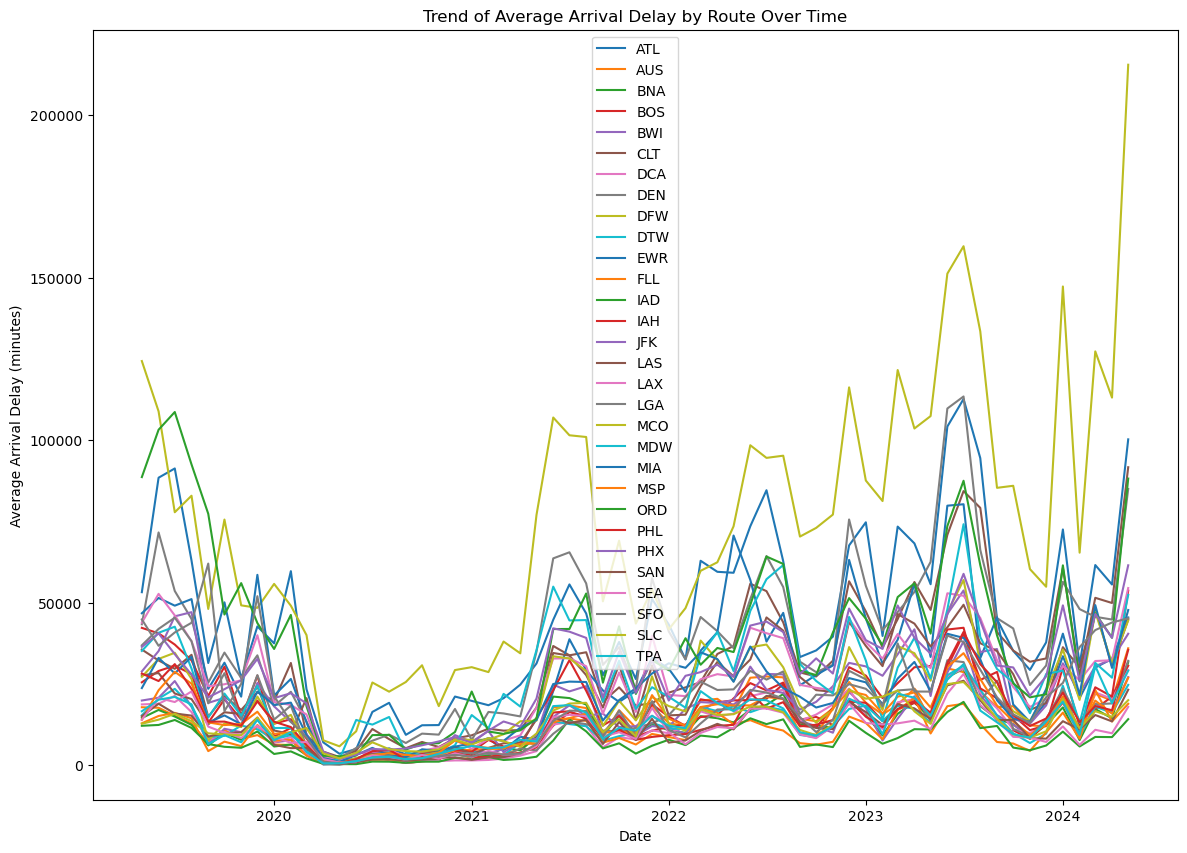

In [544]:
# Assuming 'year' and 'month' columns are available for time-based analysis
filtered_df['date'] = pd.to_datetime(filtered_df[['year', 'month']].assign(day=1))

# Calculate average monthly delay per route
monthly_delays = filtered_df.groupby(['date', 'airport'])['arr_delay'].mean().reset_index()

# Plot the trend of delays over time for top routes
plt.figure(figsize=(14, 10))
for airport in monthly_delays['airport'].unique():
    route_data = monthly_delays[monthly_delays['airport'] == airport]
    plt.plot(route_data['date'], route_data['arr_delay'], label=airport)

plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Trend of Average Arrival Delay by Route Over Time')
plt.legend()
plt.show()

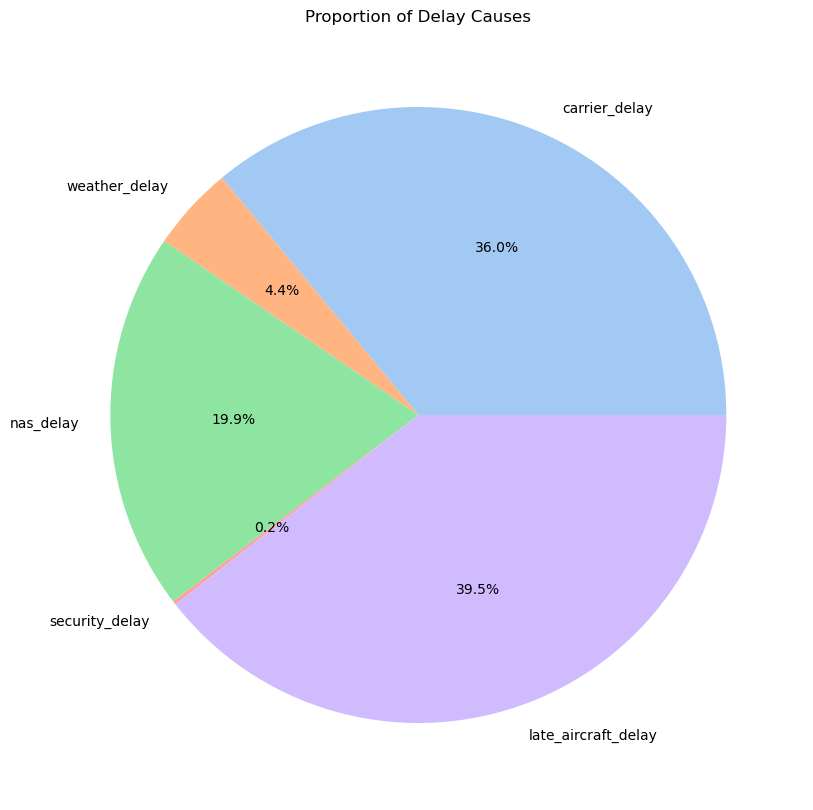

In [546]:
# Aggregate delay causes for a specific route or all routes
route_delay_causes = filtered_df.groupby('airport').agg({
    'carrier_delay': 'sum',
    'weather_delay': 'sum',
    'nas_delay': 'sum',
    'security_delay': 'sum',
    'late_aircraft_delay': 'sum'
}).sum()

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(route_delay_causes, labels=route_delay_causes.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Proportion of Delay Causes')
plt.show()

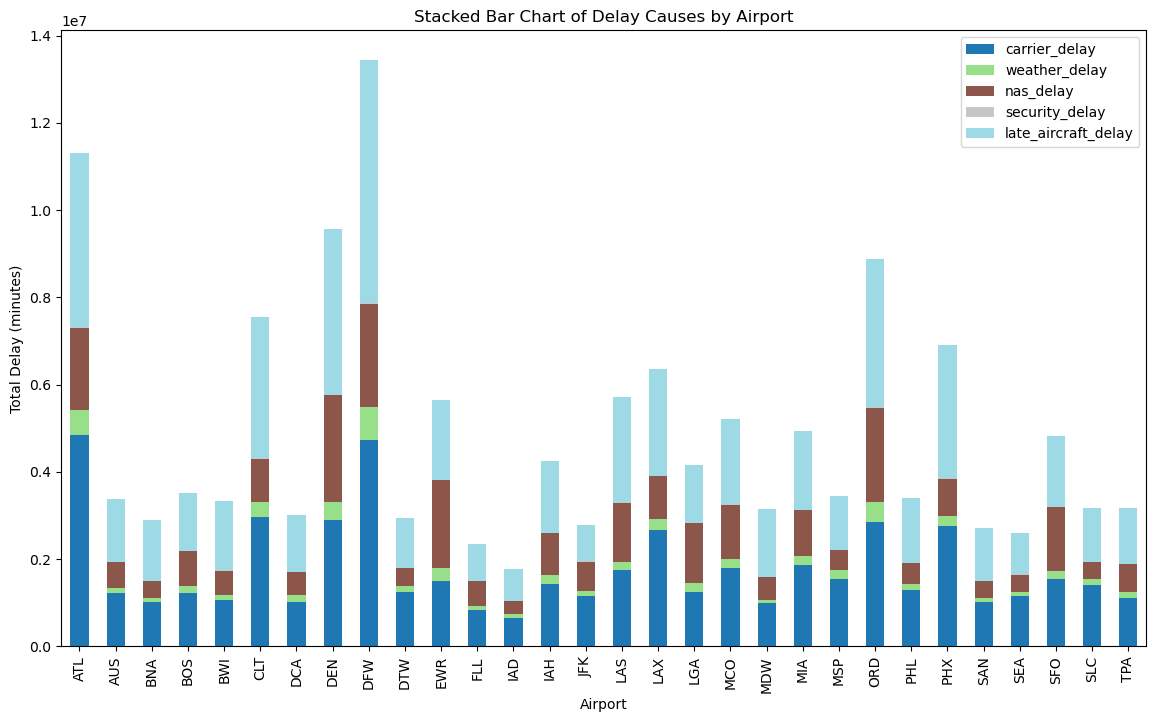

In [592]:
# Calculate total delay causes by route
delay_causes_by_route = filtered_df.groupby(['airport']).agg({
    'carrier_delay': 'sum',
    'weather_delay': 'sum',
    'nas_delay': 'sum',
    'security_delay': 'sum',
    'late_aircraft_delay': 'sum'
}).reset_index()

# Plot stacked bar chart
delay_causes_by_route.set_index('airport').plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.xlabel('Airport')
plt.ylabel('Total Delay (minutes)')
plt.title('Stacked Bar Chart of Delay Causes by Airport')
plt.xticks(rotation=90)
plt.show()

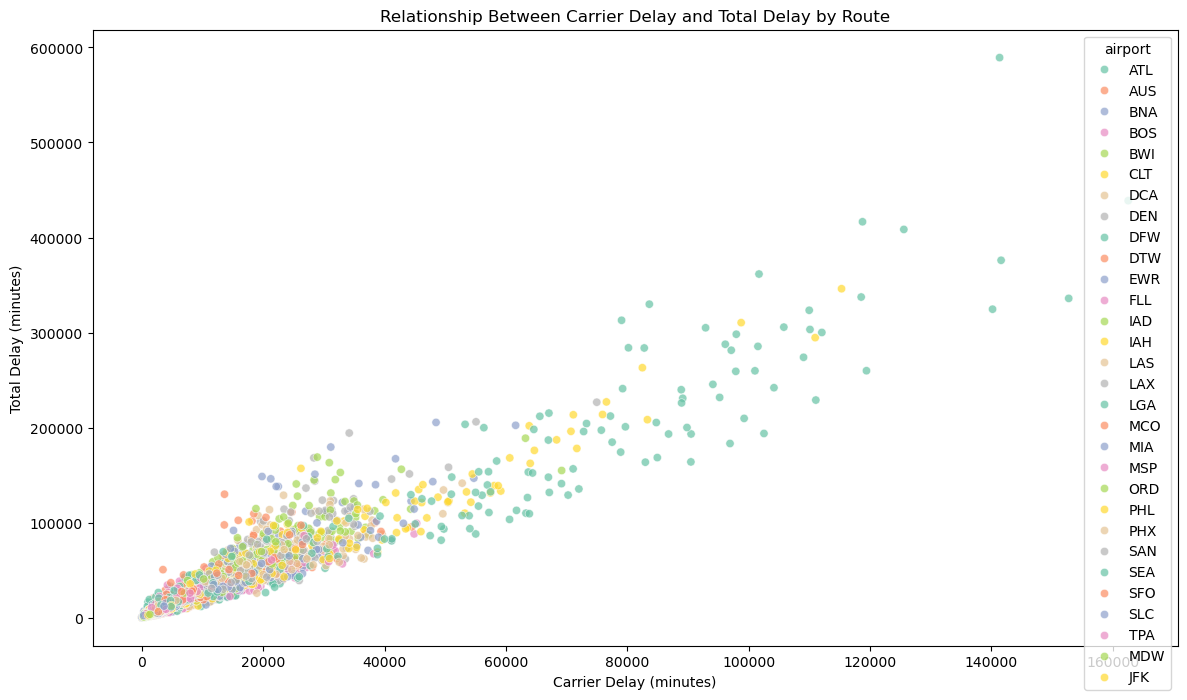

In [550]:
# Scatter plot of total delays vs. carrier delays by route
plt.figure(figsize=(14, 8))
sns.scatterplot(x='carrier_delay', y='arr_delay', data=filtered_df, hue='airport', palette='Set2', alpha=0.7)
plt.xlabel('Carrier Delay (minutes)')
plt.ylabel('Total Delay (minutes)')
plt.title('Relationship Between Carrier Delay and Total Delay by Route')
plt.show()

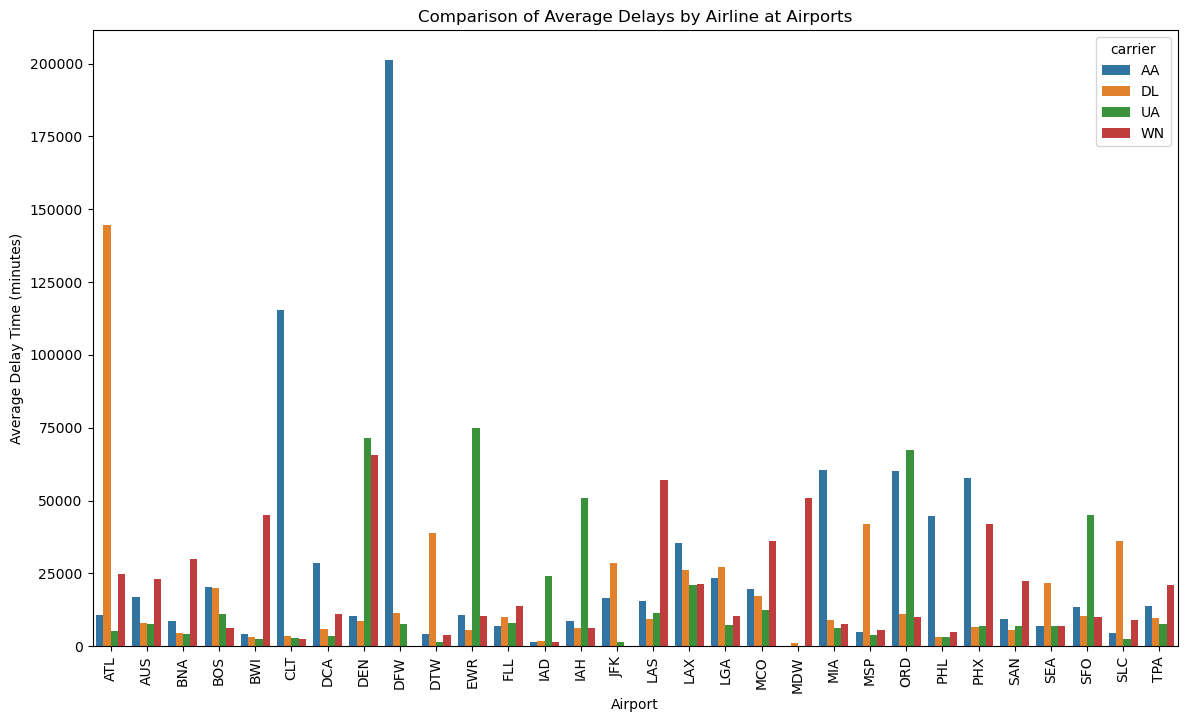

In [584]:
# Compare delays at major airports across airlines
airline_comparison = filtered_df.groupby(['airport', 'carrier'])['arr_delay'].mean().unstack()

# Reset index to get a DataFrame with 'airport' and 'carrier' as columns
df_reset = airline_comparison.reset_index()

# Melt DataFrame to get a long format suitable for seaborn
df_melted = df_reset.melt(id_vars='airport', var_name='carrier', value_name='arr_delay')

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='airport', y='arr_delay', hue='carrier', data=df_melted)
plt.xlabel('Airport')
plt.ylabel('Average Delay Time (minutes)')
plt.title('Comparison of Average Delays by Airline at Airports')
plt.xticks(rotation=90)
plt.show()

AIRLINE ANALYSIS:

1. Delays are more common at the primary hubs of each airline most likely because of the high volume of traffic and congestion typical in these areas.
2. Airports like DFW (Dallas-Fort Worth) and ATL (Atlanta) showed high total delays, with a significant portion attributed to carrier delays and late aircraft delays.
3. NAS delays were particularly prevalent at airports like DEN (Denver) and ORD (Chicago O'Hare), indicating that air traffic control issues or airspace congestion are major contributors to delays at these locations.
4. Understanding the primary delay causes allows airports to implement targeted improvements. For example, airports with high NAS delays should work on enhancing air traffic management systems.
5. Weather delays were also significant at certain airports, especially those prone to adverse weather conditions, like ATL and ORD.